In [15]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [16]:
env = gym.make('CartPole-v1')
print(env.observation_space.low, env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [17]:
max_obs_values = np.array([2.4, 4, 0.2099 , 4])
min_obs_values = np.array([-2.4, -4, -0.2099, -4])
print(min_obs_values, max_obs_values)

[-2.4    -4.     -0.2099 -4.    ] [2.4    4.     0.2099 4.    ]


In [87]:
DISCRETE_OBS_SPACE_SIZE = [10]* len(max_obs_values) # these are the what the max values will corresponds to
discrete_obs_space_step_size = (max_obs_values - min_obs_values) / DISCRETE_OBS_SPACE_SIZE

def discretizer(obs):
    # obs = np.array([obs[0], obs[2]])
    discrete_obs = (obs - min_obs_values-0.1)/discrete_obs_space_step_size
    return tuple(discrete_obs.astype(np.int16)) # tuple to make indexing easier


In [82]:
LEARNING_RATE = 0.1
DISCOUNT = 0.99
EXPLORATION_RATE = 1
EXPLORATION_DECAY_RATE = 0.00001

In [83]:
q_table = np.zeros(DISCRETE_OBS_SPACE_SIZE + [env.action_space.n])
q_table.shape

(10, 10, 10, 10, 2)

In [21]:
print(q_table[0][0][0][0])
print(q_table[(0,0,0,0)]) 

[0. 0.]
[0. 0.]


In [22]:
observation, info = env.reset()
# obs = np.array([observation[0], observation[2]])
obs = observation
print(min_obs_values, max_obs_values)
print(obs)
discrete_obs = (obs - min_obs_values)/discrete_obs_space_step_size
discrete_obs = tuple(discrete_obs.astype(np.int16))
discrete_obs

[-2.4    -4.     -0.2099 -4.    ] [2.4    4.     0.2099 4.    ]
[ 0.02870877 -0.03970408  0.04015733 -0.00687193]


(5, 4, 5, 4)

In [84]:
total_count = 0
non_zero_count = 0
for i in range(10):
    for j in range(10):
        for k in range(10):
            for l in range(10):
                probility = q_table[(i,j,k,l)]
                if np.count_nonzero(probility) != 0:
                    # print(probility)
                    non_zero_count += 1
                total_count += 1
print(non_zero_count/total_count) # it doesn't even see most of the observation combinations
# 0.1793 max i have seen for 10 discrete value for feature

0.0


In [24]:
action = 1
discrete_obs = (4, 5, 1, 3)
print(q_table[discrete_obs])

# q_table[discrete_obs + (action,)]

[0. 0.]


In [25]:
scores = []

In [91]:
num_episodes = 100000
for e in range(num_episodes):
    state, _ = env.reset()
    done = False; score_per_episode = 0
    while not done:
        discrete_state = discretizer(state) 
        action = np.argmax(q_table[discrete_state])
        if EXPLORATION_RATE > np.random.random():
             action = env.action_space.sample() 
        new_state, reward, done, _, _ = env.step(action)
        new_discrete_state = discretizer(new_state)
        # print(state, discrete_state, action)
        reward = 1 if not done else -1
        
        max_future_q = np.max(q_table[new_discrete_state])
        current_q = q_table[discrete_state + (action,)]
        new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[discrete_state + (action,)] = new_q
     
        state = new_state
        score_per_episode += reward
        
    # if e > num_episodes/2:
    EXPLORATION_RATE = max(EXPLORATION_RATE - EXPLORATION_DECAY_RATE, 0)
    scores.append(score_per_episode)
    if e % 1000 == 0:
        print(f"Episode {e}, exploration rate {EXPLORATION_RATE}, avg. score {np.mean(scores[-100:])}")
    # if score_per_episode > 2000:
    #     break
        
env.close()

# discrete state values are not really changing much


Episode 0, exploration rate 0.4500100000022255, avg. score 95.78
Episode 1000, exploration rate 0.4400100000022155, avg. score 99.44
Episode 2000, exploration rate 0.4300100000022055, avg. score 113.04
Episode 3000, exploration rate 0.4200100000021955, avg. score 112.37
Episode 4000, exploration rate 0.4100100000021855, avg. score 133.73
Episode 5000, exploration rate 0.4000100000021755, avg. score 126.86
Episode 6000, exploration rate 0.3900100000021655, avg. score 124.28
Episode 7000, exploration rate 0.3800100000021555, avg. score 153.15
Episode 8000, exploration rate 0.3700100000021455, avg. score 138.07
Episode 9000, exploration rate 0.3600100000021355, avg. score 149.19
Episode 10000, exploration rate 0.3500100000021255, avg. score 154.69
Episode 11000, exploration rate 0.3400100000021155, avg. score 109.43
Episode 12000, exploration rate 0.3300100000021055, avg. score 174.94
Episode 13000, exploration rate 0.3200100000020955, avg. score 159.56
Episode 14000, exploration rate 0.3

KeyboardInterrupt: 

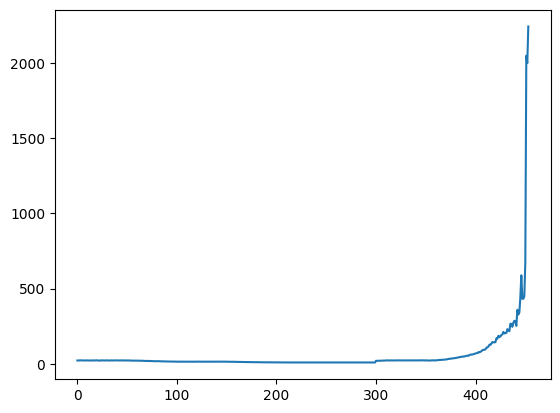

In [92]:
window_size = 1000
num_windows = len(scores) // window_size
smoothed_scores = [np.mean(scores[i*window_size:(i+1)*window_size]) for i in range(num_windows)]
plt.plot(smoothed_scores)
